## seq2seq 한영번역

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.2.0


In [3]:
path_to_file = os.getenv('HOME')+'/aiffel/s2s_translation/korean-english-park.dev.en'
with open(path_to_file, "r") as f:
    raw_en = f.read().splitlines()

path_to_file = os.getenv('HOME')+'/aiffel/s2s_translation/korean-english-park.dev.ko'    
with open(path_to_file, "r") as f:
    raw_ko = f.read().splitlines()

path_to_file = os.getenv('HOME')+'/aiffel/s2s_translation/korean-english-park.test.en'
with open(path_to_file, "r") as f:
    raw_en += f.read().splitlines()

path_to_file = os.getenv('HOME')+'/aiffel/s2s_translation/korean-english-park.test.ko'    
with open(path_to_file, "r") as f:
    raw_ko += f.read().splitlines()
    
path_to_file = os.getenv('HOME')+'/aiffel/s2s_translation/korean-english-park.train.en'
with open(path_to_file, "r") as f:
    raw_en += f.read().splitlines()

path_to_file = os.getenv('HOME')+'/aiffel/s2s_translation/korean-english-park.train.ko'    
with open(path_to_file, "r") as f:
    raw_ko += f.read().splitlines()

    
    
print("Data Size:", len(raw_en))
print("Data Size:", len(raw_ko))

print("Example:")

for sen1,sen2 in zip(raw_en[0:100][::20],raw_ko[0:100][::20]): 
    print(">>", sen1, sen2)

Data Size: 97123
Data Size: 97123
Example:
>> After keeping the world's most powerful supercomputer to themselves for a year, government researchers showed off the $110 million wonder and said it might help save the world from nuclear war. 세계 에서 가장 강력한 수퍼컴퓨터를 1년 동안이나 독점해 오던 정부의 연구학자들이 이 1억1천만 달러 짜리 경이로운 설비를 공개하며, 이것이 핵전쟁으로부터 세계를 구하는데 도움이 될지도 모른다고 말했다.
>> The head of the U.N. weapons inspection team met with an Iraqi delegation in what a Baghdad official called "useful and fruitful" discussions on the return of weapons inspectors. 무기 사찰관들의 복귀에 대하여 이라크 측의 한 관리가 "유익하고 효과적인" 논의였다고 말한 회합에서 유엔 무기 사찰단장이 이라크 대표단을 만났다.
>> "The issue of it just being a hardware expense is a serious impediment. 하드웨어를 구입하는 비용의 문제가 커다란 장애입니다.
>> Most of the people involved in the discussion agree that there is a legitimate area in which the government needs to retain the right to intercept communications. 토의에 참가한 대부분의 사람들은 정부가 통신 내용을 도청할 수 있는 권리를 보유해야 할 필요성이 있는 합법적인 부분도 있다는 데에 동의를 한다.
>> He's been known to keep a l

In [4]:
c_raw_en = list(set(raw_en))
print(len(c_raw_en))

sen_idx = {}
cleaned_corpos_en = []
cleaned_corpos_ko = []

for sen1,sen2 in zip(raw_en,raw_ko): 
    #print('!')
    if sen1 not in sen_idx:
        #print('!')
        sen_idx[sen1] = 1
        cleaned_corpos_en.append(sen1)
        cleaned_corpos_ko.append(sen2)

print(len(cleaned_corpos_en))
        
for sen1,sen2 in zip(cleaned_corpos_en[:100:20],cleaned_corpos_ko[:100:20]): 
    print(">>",sen1,sen2)

78505
78505
>> After keeping the world's most powerful supercomputer to themselves for a year, government researchers showed off the $110 million wonder and said it might help save the world from nuclear war. 세계 에서 가장 강력한 수퍼컴퓨터를 1년 동안이나 독점해 오던 정부의 연구학자들이 이 1억1천만 달러 짜리 경이로운 설비를 공개하며, 이것이 핵전쟁으로부터 세계를 구하는데 도움이 될지도 모른다고 말했다.
>> The head of the U.N. weapons inspection team met with an Iraqi delegation in what a Baghdad official called "useful and fruitful" discussions on the return of weapons inspectors. 무기 사찰관들의 복귀에 대하여 이라크 측의 한 관리가 "유익하고 효과적인" 논의였다고 말한 회합에서 유엔 무기 사찰단장이 이라크 대표단을 만났다.
>> "The issue of it just being a hardware expense is a serious impediment. 하드웨어를 구입하는 비용의 문제가 커다란 장애입니다.
>> Most of the people involved in the discussion agree that there is a legitimate area in which the government needs to retain the right to intercept communications. 토의에 참가한 대부분의 사람들은 정부가 통신 내용을 도청할 수 있는 권리를 보유해야 할 필요성이 있는 합법적인 부분도 있다는 데에 동의를 한다.
>> He's been known to keep a low profile "You will never see 

In [5]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [6]:
c_raw_en = list(set(raw_en))
print(len(c_raw_en))

sen_idx = {}
cleaned_corpos_en = []
cleaned_corpos_ko = []

for sen1,sen2 in zip(raw_en,raw_ko): 
    #print('!')
    if sen1 not in sen_idx:
        #print('!')
        sen_idx[sen1] = 1
        cleaned_corpos_en.append(sen1)
        cleaned_corpos_ko.append(sen2)

print(len(cleaned_corpos_en))
        
for sen1,sen2 in zip(cleaned_corpos_en[:100:20],cleaned_corpos_ko[:100:20]): 
    print(">>",sen1,sen2)

78505
78505
>> After keeping the world's most powerful supercomputer to themselves for a year, government researchers showed off the $110 million wonder and said it might help save the world from nuclear war. 세계 에서 가장 강력한 수퍼컴퓨터를 1년 동안이나 독점해 오던 정부의 연구학자들이 이 1억1천만 달러 짜리 경이로운 설비를 공개하며, 이것이 핵전쟁으로부터 세계를 구하는데 도움이 될지도 모른다고 말했다.
>> The head of the U.N. weapons inspection team met with an Iraqi delegation in what a Baghdad official called "useful and fruitful" discussions on the return of weapons inspectors. 무기 사찰관들의 복귀에 대하여 이라크 측의 한 관리가 "유익하고 효과적인" 논의였다고 말한 회합에서 유엔 무기 사찰단장이 이라크 대표단을 만났다.
>> "The issue of it just being a hardware expense is a serious impediment. 하드웨어를 구입하는 비용의 문제가 커다란 장애입니다.
>> Most of the people involved in the discussion agree that there is a legitimate area in which the government needs to retain the right to intercept communications. 토의에 참가한 대부분의 사람들은 정부가 통신 내용을 도청할 수 있는 권리를 보유해야 할 필요성이 있는 합법적인 부분도 있다는 데에 동의를 한다.
>> He's been known to keep a low profile "You will never see 

In [7]:
# using konlpy
vocab_size = 10000
from konlpy.tag import Mecab
tokenizer = Mecab()

def tokenize_data(train_data, num_words=vocab_size):
    X_train = []
    for sentence in train_data:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        X_train.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    # 사전 구성
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    # 변환 text to index
    X_train = list(map(wordlist_to_indexlist, X_train))

    return X_train, word_to_index

In [8]:
enc_corpus = []
dec_corpus = []

#num_examples = 30000

for en,ko in zip(cleaned_corpos_en,cleaned_corpos_ko):
    enc_corpus.append(preprocess_sentence(ko))
    dec_corpus.append(preprocess_sentence(en, s_token=True, e_token=True))

print("Korean:", enc_corpus[100])   # go away !
print("English:", dec_corpus[100])   # <start> salga de aqu ! <end>

Korean: 미국 전력회사들처럼 중국의 거대 기업들도 재생에너지에 더 많은 투자를 하고 있다 .
English: <start> like their american counterparts , chinese tycoons are increasingly directing their investment into renewable power . <end>


In [9]:
# len = 40
l_enc_corpus = []
l_dec_corpus = []

enc_tensor, word_to_index = tokenize_data(enc_corpus)

# index to text 사전
index_to_word = {index:word for word, index in word_to_index.items()}

for sen, sen2 in zip(dec_corpus,enc_tensor):
    if len(sen.split()) <= 40 and len(sen2) <= 40:
        l_enc_corpus.append(sen2)
        l_dec_corpus.append(sen)
print(len(l_enc_corpus))
#l_dec_corpus
print(l_enc_corpus[0])

62034
[46, 11, 41, 10, 2351, 2157, 8, 2425, 533, 34, 151, 10, 550, 20, 2352, 9, 1090, 11, 20, 578, 9, 2, 40, 71, 839, 49, 74, 4]


In [10]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size,filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [11]:
enc_tensor = tf.keras.preprocessing.sequence.pad_sequences(l_enc_corpus,
                                                        value=word_to_index["<PAD>"],                                                            
                                                           padding='post')
#print(enc_tensor[0])

dec_tensor, dec_tokenizer = tokenize(l_dec_corpus)

enc_train = enc_tensor
dec_train = dec_tensor

In [12]:

print(len(enc_tensor[0]))

40


In [13]:
print(len(dec_tensor[0]))

40


In [14]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [15]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [16]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [17]:

# hyperparameter
BATCH_SIZE     = 32
SRC_VOCAB_SIZE = vocab_size + 1
TGT_VOCAB_SIZE = vocab_size + 1

units         = 128
embedding_dim = 128

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

print(tf.random.uniform((BATCH_SIZE, 1)).shape)
print(sample_state.shape)
print(sample_output.shape)

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (32, 40, 128)
(32, 1)
(32, 128)
(32, 40, 128)
Decoder Output: (32, 10001)
Decoder Hidden State: (32, 128)
Attention: (32, 40, 1)


In [18]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [19]:

@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [20]:
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    return batch_loss


# Training Process

from tqdm import tqdm
import random
EPOCHS = 30

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
# validation (노드에서 모든 데이터 셋을 훈련 데이터로 사용하라고 했다. 데이터 양이 부족하기 때문에) 즉 생략
#     test_loss = 0

#     idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
#     random.shuffle(idx_list)
#     t = tqdm(idx_list)

#     for (test_batch, idx) in enumerate(t):
#         test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
#                                     dec_val[idx:idx+BATCH_SIZE],
#                                     encoder,
#                                     decoder,
#                                     dec_tokenizer)

#         test_loss += test_batch_loss

#         t.set_description_str('Test Epoch %2d' % (epoch + 1))
#         t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Epoch 30: 100%|██████████| 1939/1939 [06:02<00:00,  5.34it/s, Loss 1.6600]


/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


Input: 새로운 시간이다 .
Predicted translation: new new york cnn . <end> 


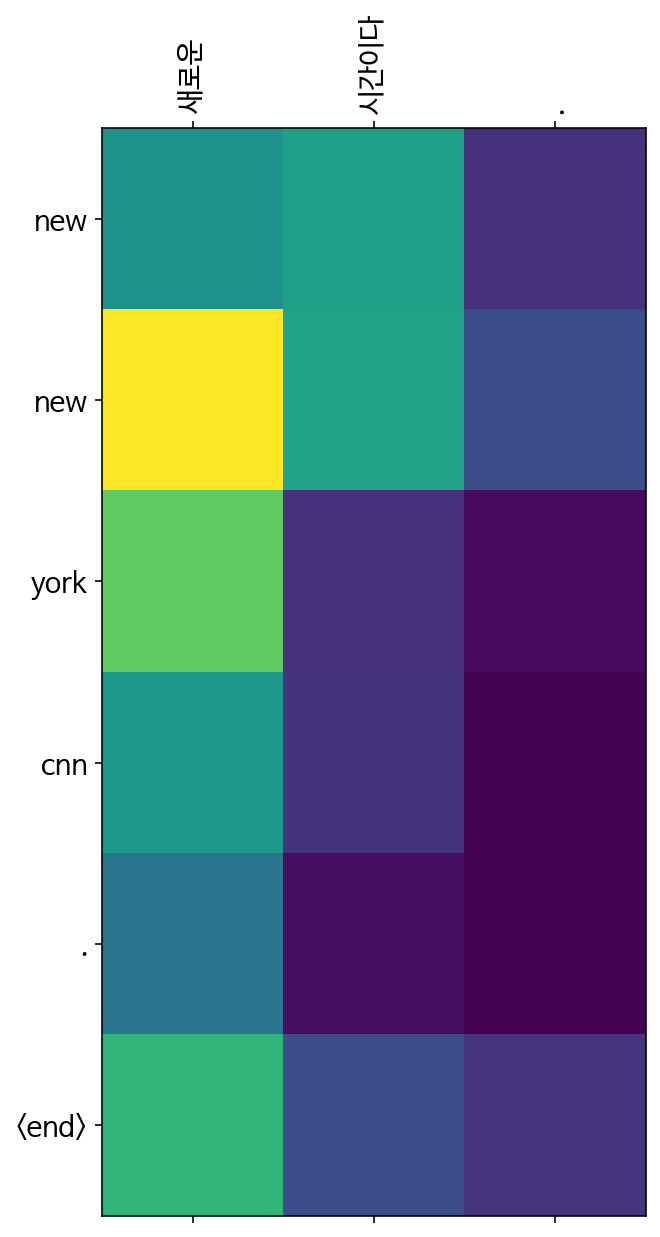

In [21]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = tokenizer.morphs(sentence)
    
    inputss = []
    for s in inputs:
        if s not in word_to_index:
                inputss.append(word_to_index['<UNK>'])
        else: inputss.append(word_to_index[s])
    inputs = [inputss]
    
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           value=word_to_index["<PAD>"],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''
    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']]*1, 0)

    
    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


str_t = "새로운 시간이다." 
translate(str_t, encoder, decoder)


Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: eight deaths , the death toll was killed . <end> 


/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


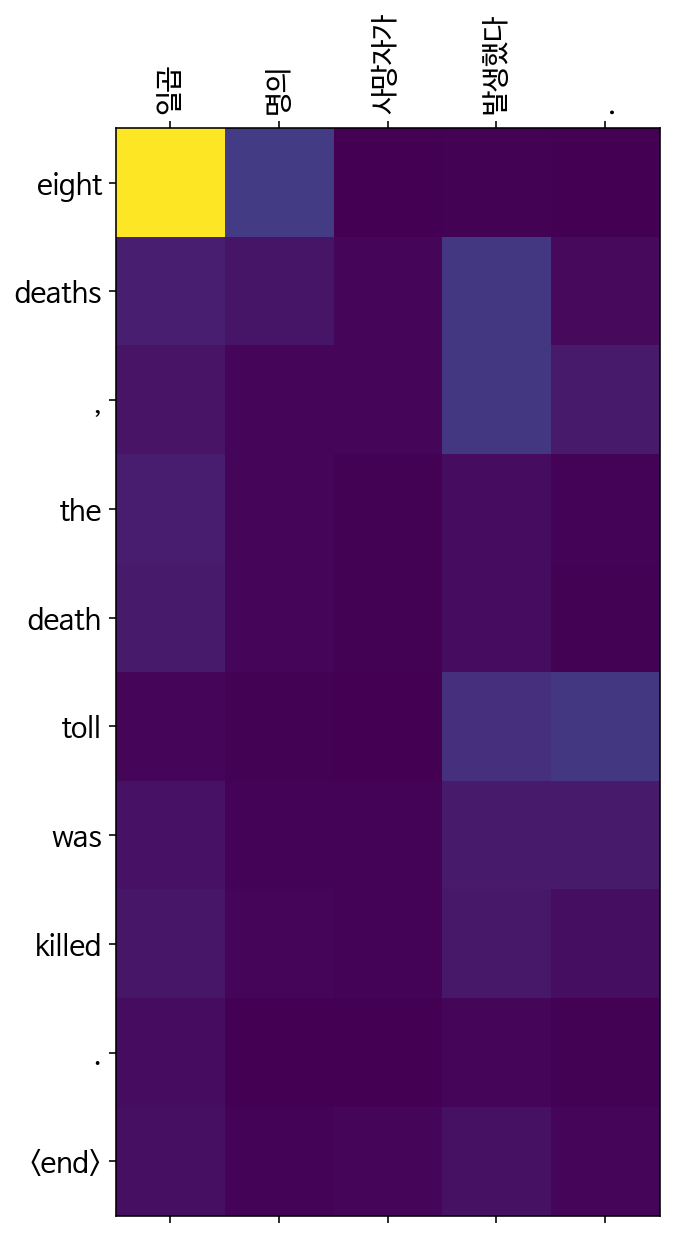

In [22]:
str_t = "일곱 명의 사망자가 발생했다." 
translate(str_t, encoder, decoder)

Input: 커피는 필요 없다 .
Predicted translation: you can t be a lot of your destination <end> 


/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


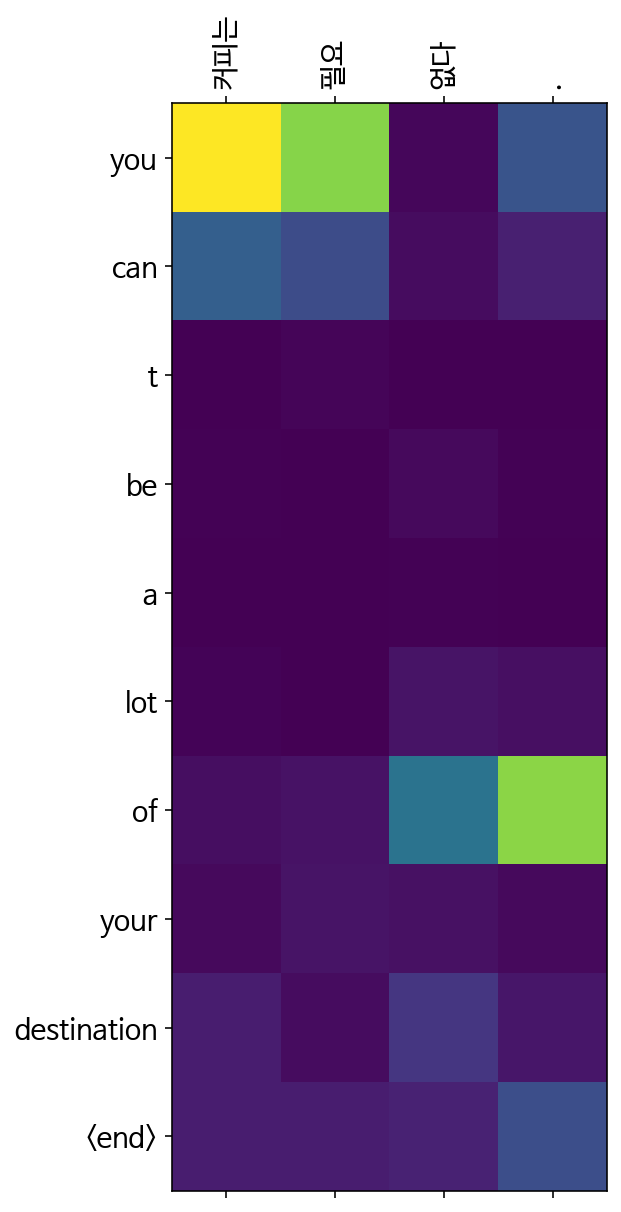

In [23]:
str_t = "커피는 필요 없다." 
translate(str_t, encoder, decoder)

Input: 시민들은 도시 속에 산다 .
Predicted translation: they are just over the world s most beautiful . <end> 


/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


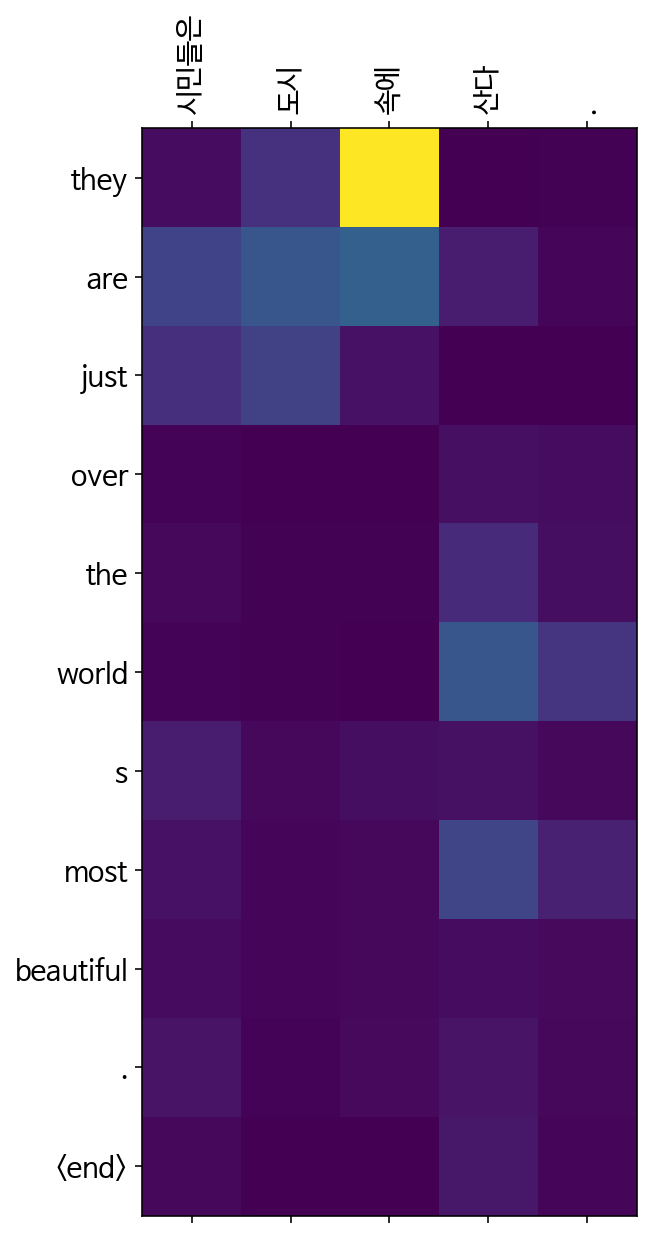

In [24]:
str_t = "시민들은 도시 속에 산다." 
translate(str_t, encoder, decoder)

Input: 오바마는 대통령이다 .
Predicted translation: obama is a obama campaign . <end> 


/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


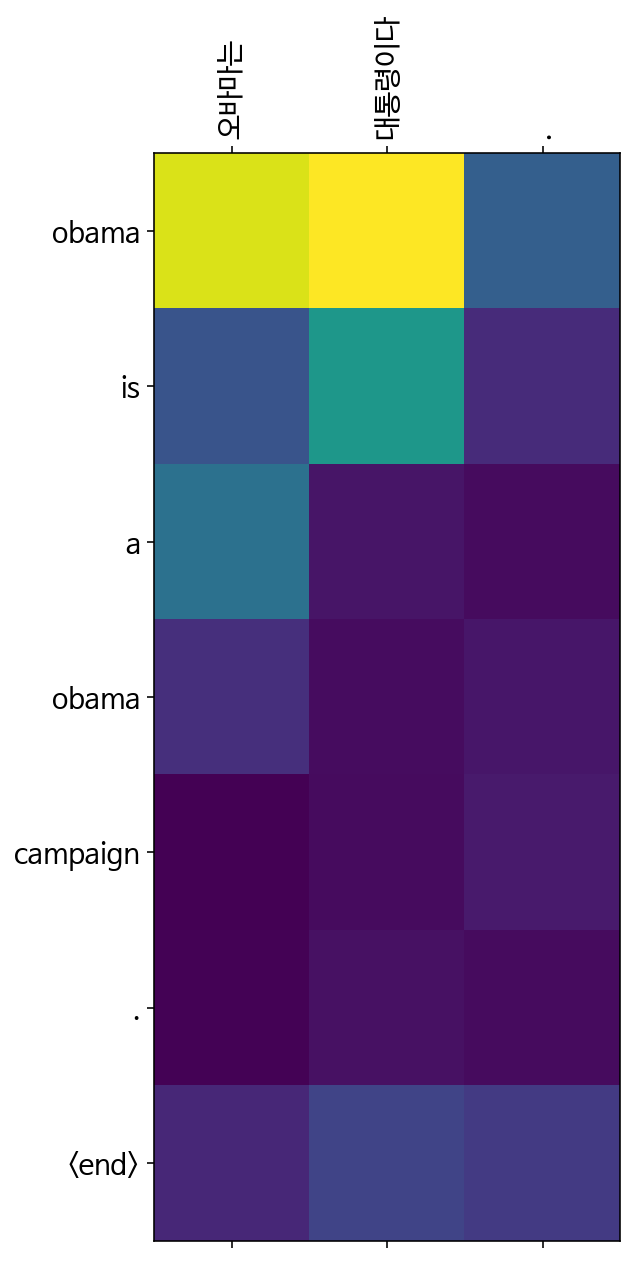

In [25]:
str_t = "오바마는 대통령이다." 
translate(str_t, encoder, decoder)

결과는 목표단어가 하나 정도 나오는데에 그쳤다. 언어 모델의 구조가 익숙치 않은데에 seq2seq의 개념도 명확히 와닿지 않아서 프로젝트를 진행하는데 꽤 힘이 많이 들었다. 하지만 이 프로젝트를 통해서 현재 번역사이트 및 어플들이 개략적으로 어떻게 돌아가겠구나 하는 생각을 줄 수 있었다.